In [134]:
""" Utility functions. """
import pdb
import numpy as np
import os
import random
import tensorflow as tf

## Loss utilities
def cross_entropy_loss(pred, label, k_shot):
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=tf.stop_gradient(label)) / k_shot)

def accuracy(labels, predictions):
    return tf.reduce_mean(tf.cast(tf.equal(labels, predictions), dtype=tf.float32))
    

In [144]:
"""Data loading scripts"""
from scipy import misc
import imageio
from skimage import io
from skimage import transform
from PIL import Image
import copy

def get_images(paths, labels, n_samples=None, shuffle=True):
    """
    Takes a set of character folders and labels and returns paths to image files
    paired with labels.
    Args:
    paths: A list of character folders
    labels: List or numpy array of same length as paths
    n_samples: Number of images to retrieve per character
    Returns:
    List of (label, image_path) tuples
    """
    if n_samples is not None:
        sampler = lambda x: random.sample(x, n_samples)
    else:
        sampler = lambda x: x
    images_labels = [(i, os.path.join(path, image))
           for i, path in zip(labels, paths)
           for image in sampler(os.listdir(path))]
    if shuffle:
        random.shuffle(images_labels)
    return images_labels


def image_file_to_array(filename, dim_input, shear=None, scale=None):
    """
    Takes an image path and returns numpy array
    Args:
    filename: Image filename
    dim_input: Flattened shape of image
    Returns:
    1 channel image
    """
    image = imageio.imread(filename)
    if 'mnist' in filename:
        image = image>150
        image = image.astype(np.int8)
    if 'hand_digits' in filename:
        image = image[:,:,0]
        image = image>150
        image = image.astype(np.int8)
#         print(image)
    
    if shear is not None:
        afine_tf = transform.AffineTransform(shear=shear)
        image = transform.warp(image, inverse_map=afine_tf.inverse)

    elif scale is not None:
        afine_tf = transform.AffineTransform(scale=scale)
        image = transform.warp(image, inverse_map=afine_tf.inverse)
#     pdb.set_trace()
    image = transform.resize(image,(28,28),anti_aliasing=False,order=0)*255
#     pdb.set_trace()
    image = image.reshape([dim_input])
    image = image.astype(np.float32) / 255.0
    if 'mnist' in filename:
        return image
    image = 1.0 - image
    return image


class DataGenerator(object):
    """
    Data Generator capable of generating batches of Omniglot data.
    A "class" is considered a class of omniglot digits.
    """

    def __init__(self, num_classes, num_samples_per_class, num_meta_test_classes, num_meta_test_samples_per_class, config={}):
        """
        Args:
          num_classes: Number of classes for classification (K-way)
          num_samples_per_class: num samples to generate per class in one batch
          num_meta_test_classes: Number of classes for classification (K-way) at meta-test time
          num_meta_test_samples_per_class: num samples to generate per class in one batch at meta-test time
          batch_size: size of meta batch size (e.g. number of functions)
        """
        self.num_samples_per_class = num_samples_per_class
        self.num_classes = num_classes
        self.num_meta_test_samples_per_class = num_meta_test_samples_per_class
        self.num_meta_test_classes = num_meta_test_classes

        data_folder = config.get('data_folder', './omniglot')
        self.img_size = config.get('img_size', (28, 28))
        self.dim_input = np.prod(self.img_size)
        self.dim_output = self.num_classes
        
        if isinstance(data_folder,str):            

            character_folders = [os.path.join(data_folder, family, character)
                       for family in os.listdir(data_folder)
                       if os.path.isdir(os.path.join(data_folder, family))
                       for character in os.listdir(os.path.join(data_folder, family))
                       if os.path.isdir(os.path.join(data_folder, family, character))]
            random.seed(42)
            random.shuffle(character_folders)
            num_val = 100
            num_train = 1100
            self.metatrain_character_folders = character_folders[: num_train]
            self.metaval_character_folders = character_folders[
              num_train:num_train + num_val]
            self.metatest_character_folders = character_folders[
              num_train + num_val:]
        else:
            train_folders = [os.path.join(data_folder[0], family, character)
                       for family in os.listdir(data_folder[0])
                       if os.path.isdir(os.path.join(data_folder[0], family))
                       for character in os.listdir(os.path.join(data_folder[0], family))
                       if os.path.isdir(os.path.join(data_folder[0], family, character))]
            test_folders = [os.path.join(data_folder[1], family, character)
                       for family in os.listdir(data_folder[1])
                       if os.path.isdir(os.path.join(data_folder[1], family))
                       for character in os.listdir(os.path.join(data_folder[1], family))
                       if os.path.isdir(os.path.join(data_folder[1], family, character))]
            random.seed(42)
            random.shuffle(train_folders)
            self.metatrain_character_folders = copy.deepcopy(train_folders)
            self.metaval_character_folders = copy.deepcopy(train_folders)
            self.metatest_character_folders = test_folders

    def sample_batch(self, batch_type, batch_size, shuffle=True, swap=False, shear=None, scale=None):
        """
        Samples a batch for training, validation, or testing
        Args:
          batch_type: meta_train/meta_val/meta_test
          shuffle: randomly shuffle classes or not
          swap: swap number of classes (N) and number of samples per class (K) or not
        Returns:
          A a tuple of (1) Image batch and (2) Label batch where
          image batch has shape [B, N, K, 784] and label batch has shape [B, N, K, N] if swap is False
          where B is batch size, K is number of samples per class, N is number of classes
        """
        if batch_type == "meta_train":
            folders = self.metatrain_character_folders
            num_classes = self.num_classes
            num_samples_per_class = self.num_samples_per_class
        elif batch_type == "meta_val":
            folders = self.metaval_character_folders
            num_classes = self.num_classes
            num_samples_per_class = self.num_samples_per_class
        else:
            folders = self.metatest_character_folders
            num_classes = self.num_meta_test_classes
            num_samples_per_class = self.num_meta_test_samples_per_class

        all_image_batches, all_label_batches = [], []
        for i in range(batch_size):
            sampled_character_folders = random.sample(
            folders, num_classes)
            labels_and_images = get_images(sampled_character_folders, range(
            num_classes), n_samples=num_samples_per_class, shuffle=False)
            labels = [li[0] for li in labels_and_images]
            images = [image_file_to_array(
            li[1], self.dim_input,shear,scale) for li in labels_and_images]
            images = np.stack(images)
            labels = np.array(labels).astype(np.int32)
            labels = np.reshape(
            labels, (num_classes, num_samples_per_class))
            labels = np.eye(num_classes, dtype=np.float32)[labels]
            images = np.reshape(
            images, (num_classes, num_samples_per_class, -1))

            batch = np.concatenate([labels, images], 2)
            if shuffle:
                for p in range(num_samples_per_class):
                    np.random.shuffle(batch[:, p])

            labels = batch[:, :, :num_classes]
            images = batch[:, :, num_classes:]

            if swap:
                labels = np.swapaxes(labels, 0, 1)
                images = np.swapaxes(images, 0, 1)

            all_image_batches.append(images)
            all_label_batches.append(labels)
        all_image_batches = np.stack(all_image_batches)
        all_label_batches = np.stack(all_label_batches)
        return all_image_batches, all_label_batches

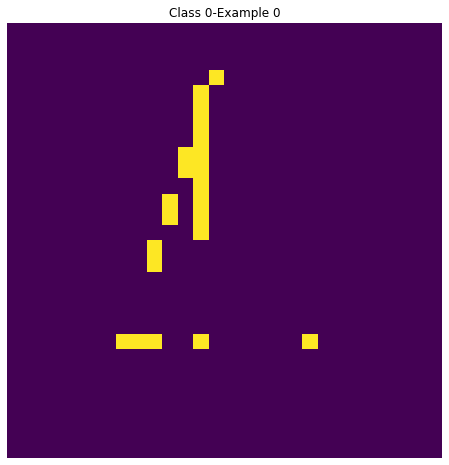

In [129]:
# ### Debug 
data_generator = DataGenerator(1, 1,1,1,config={'data_folder':['mnist', 'hand_digits']})
i, l = data_generator.sample_batch('meta_test', 6)
b = 1
from matplotlib import pyplot as plt
plt.figure(figsize=(8, 8))
cnt = 0
for c in range(1):
    for k in range(1):
        plt.subplot(1, 1, cnt + 1)
        plt.title(f'Class {c}-Example {k}')
        image = i[b, c, k].reshape((28,28))
        plt.imshow(image)
        plt.axis('off');
        cnt += 1
plt.show()

In [152]:
#RelationNet
from tensorflow.keras import layers
from tensorflow.keras import losses

class RelationNet(tf.keras.Model):

    def __init__(self, num_filters = 64, hidden_dim = 16):
        super(RelationNet, self).__init__()
#         self.num_filters = num_filters
#         # self.latent_dim = latent_dim
#         num_filter_list = [self.num_filters]*2
#         self.convs = []
#         for i, num_filter in enumerate(num_filter_list):
#             block_parts = [
#             layers.Conv2D(
#               filters=num_filter,
#               kernel_size=3,
#               padding='SAME',
#               activation='linear'),
#             ]

#             block_parts += [layers.BatchNormalization(momentum = 1)]
#             block_parts += [layers.Activation('relu')]
#             block_parts += [layers.MaxPool2D()]
#             block = tf.keras.Sequential(block_parts, name='conv_block_%d' % i)
#             self.__setattr__("conv%d" % i, block)
#             self.convs.append(block)
#         self.flatten = tf.keras.layers.Flatten()
        self.fc1 = layers.Dense(hidden_dim,activation = 'relu')
        self.fc2 = layers.Dense(1,activation = 'sigmoid')

    def call(self, inp):
        out = inp
        # for conv in self.convs:
          # out = conv(out)
        # out = self.flatten(out)
        out = self.fc2(self.fc1(out))
        return out

def RelationLoss(x_latent, q_latent, labels_onehot, num_classes, num_support, num_queries, relation_net):
    """
    calculates the prototype network loss using the latent representation of x
    and the latent representation of the query set
    Args:
      x_latent: latent representation of supports with shape [N*S, D], where D is the latent dimension
      q_latent: latent representation of queries with shape [N*Q, D], where D is the latent dimension
      labels_onehot: one-hot encodings of the labels of the queries with shape [N, Q, N]
      num_classes: number of classes (N) for classification
      num_support: number of examples (S) in the support set
      num_queries: number of examples (Q) in the query set
    Returns:
      ce_loss: the cross entropy loss between the predicted labels and true labels
      acc: the accuracy of classification on the queries
    """
    x = tf.reshape(x_latent, shape=[num_classes, num_support, -1])
    # print(x.numpy().shape)
    prototypes = tf.reduce_mean(x, axis = 1, keepdims=False) #(N, D)
    prototypes_ext = tf.repeat(prototypes, repeats = [num_classes*num_queries]*num_classes, axis = 0) #(N*Q*N, D)
    q_ext = tf.tile(q_latent, multiples = [num_classes,1]) # (N*N*Q, D)
    labels_ = tf.reshape(labels_onehot, [-1, num_classes]) #(N*Q, N)
    scores_ = relation_net(tf.concat([q_ext, prototypes_ext], axis = -1)) #(N*NQ, 1)
    scores_ = tf.split(scores_,num_classes,0)
    scores = tf.concat(scores_, axis = -1) #(NQ,N)

    loss = losses.mean_squared_error(labels_, scores) #(NQ,)
    loss = tf.reduce_mean(loss)#+tf.reduce_sum(tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.REGULARIZATION_LOSSES)) #(1,)

#     loss = cross_entropy_loss(scores,labels_, k_shot=1)
    acc = accuracy(tf.argmax(input=labels_, axis=1), tf.argmax(input=scores, axis=1))
    # print(ce_loss.numpy())
    # print(acc.numpy())

    # print(error)
    return loss, acc


#Shape checking

# q = tf.random.uniform(shape = [10,5])
# print(q.shape)
# q_ext = tf.tile(q, multiples = [2,1])
# q_rep = tf.repeat(q, repeats = [2], axis = 0)
# print(q_rep.shape)
# print(q)
# print(q_rep)
# print(tf.concat([q,q], axis = -1))


# t = tf.random.uniform(shape = [12,1])
# t_ = tf.split(t,3,0)
# t__ = tf.concat(t_, axis = -1)

# t1 = tf.random.uniform(shape = [12,1])
# t1_ = tf.split(t1,3,0)
# t1__ = tf.concat(t1_, axis = -1)

# print(losses.mean_squared_error(t__,t1__,))

# print(t)
# print(t_)
# print(t__)


In [137]:
# models/ProtoNet
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

class ProtoNet(tf.keras.Model):

  def __init__(self, num_filters, latent_dim):
    super(ProtoNet, self).__init__()
    self.num_filters = num_filters
    self.latent_dim = latent_dim
    num_filter_list = self.num_filters + [latent_dim]
    self.convs = []
    for i, num_filter in enumerate(num_filter_list):
      block_parts = [
        layers.Conv2D(
          filters=num_filter,
          kernel_size=3,
          padding='SAME',
          activation='linear'),
      ]

      block_parts += [layers.BatchNormalization()]
      block_parts += [layers.Activation('relu')]
      block_parts += [layers.MaxPool2D()]
      block = tf.keras.Sequential(block_parts, name='conv_block_%d' % i)
      self.__setattr__("conv%d" % i, block)
      self.convs.append(block)
    self.flatten = tf.keras.layers.Flatten()

  def call(self, inp):
    out = inp
    for conv in self.convs:
      out = conv(out)
    out = self.flatten(out)
    return out

def ProtoLoss(x_latent, q_latent, labels_onehot, num_classes, num_support, num_queries):
  """
    calculates the prototype network loss using the latent representation of x
    and the latent representation of the query set
    Args:
      x_latent: latent representation of supports with shape [N*S, D], where D is the latent dimension
      q_latent: latent representation of queries with shape [N*Q, D], where D is the latent dimension
      labels_onehot: one-hot encodings of the labels of the queries with shape [N, Q, N]
      num_classes: number of classes (N) for classification
      num_support: number of examples (S) in the support set
      num_queries: number of examples (Q) in the query set
    Returns:
      ce_loss: the cross entropy loss between the predicted labels and true labels
      acc: the accuracy of classification on the queries
  """
  x_latent = tf.reshape(x_latent,[num_classes,num_support,-1])
  c = tf.reduce_mean(x_latent,axis=1)
  def dist(q, c):
    N_Q, D = q.shape
    N = c.shape[0]
    q = tf.tile(tf.expand_dims(q, axis=1), [1, N, 1])
    c = tf.tile(tf.expand_dims(c, axis=0), [N_Q, 1, 1])
    return tf.reduce_mean(tf.square(q-c), axis=2)
  distances = tf.reshape(dist(q_latent, c), [num_classes,num_queries,num_classes])
  ce_loss = cross_entropy_loss(-distances, labels_onehot, 1)
  acc = accuracy(tf.argmax(labels_onehot, axis=-1),tf.argmax(tf.reshape(tf.nn.softmax(-distances), 
                                                                 [num_classes, num_queries, -1]), axis=-1))
  #############################
  return ce_loss, acc

In [155]:
# run_ProtoNet
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import os
import glob
import matplotlib.pyplot as plt

def proto_net_train_step(model, optim, x, q, labels_ph, rel=None):
    num_classes, num_support, im_height, im_width, channels = x.shape
    num_queries = q.shape[1]
    x = tf.reshape(x, [-1, im_height, im_width, channels])
    q = tf.reshape(q, [-1, im_height, im_width, channels])

    with tf.GradientTape() as tape:
        x_latent = model(x)
        q_latent = model(q)
        if rel is None:
            ce_loss, acc = ProtoLoss(x_latent, q_latent, labels_ph, num_classes, num_support, num_queries)
        else:
            ce_loss, acc = RelationLoss(x_latent, q_latent, labels_ph, num_classes, num_support, num_queries,rel)

    if rel is None:
        gradients = tape.gradient(ce_loss, model.trainable_variables)
        optim.apply_gradients(zip(gradients, model.trainable_variables))
    else:
        gradients = tape.gradient(ce_loss, model.trainable_variables+rel.trainable_variables)
#         print(model.trainable_variables+rel.trainable_variables)
#         1/0
        optim.apply_gradients(zip(gradients, model.trainable_variables+rel.trainable_variables))
    
    return ce_loss, acc

def proto_net_eval(model, x, q, labels_ph,rel=None):
  num_classes, num_support, im_height, im_width, channels = x.shape
  num_queries = q.shape[1]
  x = tf.reshape(x, [-1, im_height, im_width, channels])
  q = tf.reshape(q, [-1, im_height, im_width, channels])

  x_latent = model(x)
  q_latent = model(q)
  if rel is None:
    ce_loss, acc = ProtoLoss(x_latent, q_latent, labels_ph, num_classes, num_support, num_queries)
  else:
    ce_loss, acc = RelationLoss(x_latent, q_latent, labels_ph, num_classes, num_support, num_queries,rel)

  return ce_loss, acc 

def run_protonet(data_path='./omniglot', n_way=20, k_shot=1, n_query=5, n_meta_test_way=20, 
                 k_meta_test_shot=5, n_meta_test_query=5,shear=None,scale=None, rel=False, n_epochs=20, latent_dim = 16):
  
  n_episodes = 100

  im_width, im_height, channels = 28, 28, 1
  num_filters = 32
  num_conv_layers = 3
  n_meta_test_episodes = 1000

  model = ProtoNet([num_filters]*num_conv_layers, latent_dim)
  if not rel:
    rel_model=None
  else:
    rel_model = RelationNet()
  optimizer = tf.keras.optimizers.Adam()

    # call DataGenerator with k_shot+n_query samples per class
  data_generator = DataGenerator(n_way, k_shot+n_query, n_meta_test_way, k_meta_test_shot+n_meta_test_query,
                                 config={'data_folder':data_path})
  for ep in range(n_epochs):
    for epi in range(n_episodes):
      image_batch, label_batch = data_generator.sample_batch('meta_train',1,shuffle=False)
      image, label = image_batch[0], label_batch[0]
      support,query = image[:,:k_shot,:], image[:,k_shot:,:]
      labels = label[:,k_shot:,:]
      # Reshape
      support = tf.reshape(support,[-1,k_shot,im_width, im_height, channels])
      query = tf.reshape(query,[-1,n_query,im_width, im_height, channels])
      #############################
      ls, ac = proto_net_train_step(model, optimizer, x=support, q=query, labels_ph=labels, rel=rel_model)
      if (epi+1) % 50 == 0:
        image_batch, label_batch = data_generator.sample_batch('meta_val',1,shuffle=False)
        image, label = image_batch[0], label_batch[0]
        support,query = image[:,:k_shot,:], image[:,k_shot:,:]
        labels = label[:,k_shot:,:]
        # Reshape
        support = tf.reshape(support,[-1,k_shot,im_width, im_height, channels])
        query = tf.reshape(query,[-1,n_query,im_width, im_height, channels])
        #############################
        val_ls, val_ac = proto_net_eval(model, x=support, q=query, labels_ph=labels, rel=rel_model)
        print('[epo {}/{}, epi {}/{}] => meta-training loss: {:.5f}, meta-training acc: {:.5f}, meta-val loss: {:.5f}, meta-val acc: {:.5f}'.format(ep+1,
                                                                    n_epochs,
                                                                    epi+1,
                                                                    n_episodes,
                                                                    ls,
                                                                    ac,
                                                                    val_ls,
                                                                    val_ac))

  print('Testing...')
  meta_test_accuracies = []
  for epi in range(n_meta_test_episodes):
    # sample a batch of test data and partition into
    # support and query sets
    image_batch, label_batch = data_generator.sample_batch('meta_test',1,shuffle=False,shear=shear,scale=scale)
    image, label = image_batch[0], label_batch[0]
    support,query = image[:,:k_meta_test_shot,:], image[:,k_meta_test_shot:,:]
    labels = label[:,k_meta_test_shot:,:]
    # Reshape
    support = tf.reshape(support,[-1,k_meta_test_shot,im_width, im_height, channels])
    query = tf.reshape(query,[-1,n_meta_test_query,im_width, im_height, channels])
    #############################
    ls, ac = proto_net_eval(model, x=support, q=query, labels_ph=labels,rel=rel_model)
    meta_test_accuracies.append(ac)
    if (epi+1) % 50 == 0:
      print('[meta-test episode {}/{}] => loss: {:.5f}, acc: {:.5f}'.format(epi+1, n_meta_test_episodes, ls, ac))
  avg_acc = np.mean(meta_test_accuracies)
  stds = np.std(meta_test_accuracies)
  print('Average Meta-Test Accuracy: {:.5f}, Meta-Test Accuracy Std: {:.5f}'.format(avg_acc, stds))
  # return meta_test_accuracies, 

In [156]:
run_protonet(data_path=['mnist', 'hand_digits'], n_way=5, k_shot=1, n_query=5, n_meta_test_way=5,
                 k_meta_test_shot=1, n_meta_test_query=5,latent_dim = 16, rel=True)

[epo 1/20, epi 50/100] => meta-training loss: 0.16069, meta-training acc: 0.20000, meta-val loss: 0.16069, meta-val acc: 0.20000
[epo 1/20, epi 100/100] => meta-training loss: 0.16000, meta-training acc: 0.20000, meta-val loss: 0.16000, meta-val acc: 0.20000
[epo 2/20, epi 50/100] => meta-training loss: 0.16000, meta-training acc: 0.20000, meta-val loss: 0.16000, meta-val acc: 0.20000
[epo 2/20, epi 100/100] => meta-training loss: 0.16000, meta-training acc: 0.20000, meta-val loss: 0.16000, meta-val acc: 0.20000
[epo 3/20, epi 50/100] => meta-training loss: 0.16000, meta-training acc: 0.20000, meta-val loss: 0.16000, meta-val acc: 0.20000
[epo 3/20, epi 100/100] => meta-training loss: 0.16000, meta-training acc: 0.20000, meta-val loss: 0.16000, meta-val acc: 0.20000
[epo 4/20, epi 50/100] => meta-training loss: 0.16000, meta-training acc: 0.20000, meta-val loss: 0.16000, meta-val acc: 0.20000
[epo 4/20, epi 100/100] => meta-training loss: 0.16000, meta-training acc: 0.20000, meta-val l

KeyboardInterrupt: 

In [20]:
for p in range(25,201,25):
    p = p/100
    print(f'\n========================Performing scale={p}=========================\n')
    run_protonet(data_path='./omniglot', n_way=5, k_shot=1, n_query=5, n_meta_test_way=5,
                 k_meta_test_shot=1, n_meta_test_query=5,shear=None,scale=p,latent_dim = 16)


========================Performing scale=0.25=========================

[epo 1/20, epi 50/100] => meta-training loss: 1.47260, meta-training acc: 0.44000, meta-val loss: 0.95442, meta-val acc: 0.60000
[epo 1/20, epi 100/100] => meta-training loss: 0.52572, meta-training acc: 0.80000, meta-val loss: 0.52896, meta-val acc: 0.88000
[epo 2/20, epi 50/100] => meta-training loss: 0.90389, meta-training acc: 0.64000, meta-val loss: 0.63522, meta-val acc: 0.76000
[epo 2/20, epi 100/100] => meta-training loss: 0.59887, meta-training acc: 0.72000, meta-val loss: 0.62829, meta-val acc: 0.84000
[epo 3/20, epi 50/100] => meta-training loss: 0.43263, meta-training acc: 0.84000, meta-val loss: 0.63060, meta-val acc: 0.88000
[epo 3/20, epi 100/100] => meta-training loss: 1.10159, meta-training acc: 0.48000, meta-val loss: 0.58155, meta-val acc: 0.80000
[epo 4/20, epi 50/100] => meta-training loss: 1.11795, meta-training acc: 0.64000, meta-val loss: 0.51839, meta-val acc: 0.88000
[epo 4/20, epi 100/10

In [11]:
for p in range(100,101,25):
    p = p/100
    print(f'\n========================Performing scale={p}=========================\n')
    run_protonet(data_path='./omniglot', n_way=5, k_shot=1, n_query=5, n_meta_test_way=5,
                 k_meta_test_shot=1, n_meta_test_query=5,shear=None,scale=p,rel=True,n_epochs=50,latent_dim = 16)


========================Performing scale=1.0=========================

[epo 1/50, epi 50/100] => meta-training loss: 0.16025, meta-training acc: 0.20000, meta-val loss: 0.16035, meta-val acc: 0.20000
[epo 1/50, epi 100/100] => meta-training loss: 0.15992, meta-training acc: 0.20000, meta-val loss: 0.16000, meta-val acc: 0.20000
[epo 2/50, epi 50/100] => meta-training loss: 0.15985, meta-training acc: 0.20000, meta-val loss: 0.15979, meta-val acc: 0.20000
[epo 2/50, epi 100/100] => meta-training loss: 0.15984, meta-training acc: 0.20000, meta-val loss: 0.15946, meta-val acc: 0.20000
[epo 3/50, epi 50/100] => meta-training loss: 0.15277, meta-training acc: 0.56000, meta-val loss: 0.15348, meta-val acc: 0.56000
[epo 3/50, epi 100/100] => meta-training loss: 0.14445, meta-training acc: 0.44000, meta-val loss: 0.14640, meta-val acc: 0.44000
[epo 4/50, epi 50/100] => meta-training loss: 0.15471, meta-training acc: 0.40000, meta-val loss: 0.15154, meta-val acc: 0.44000
[epo 4/50, epi 100/100